## Imports

In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import yfinance as yf
import cplex

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cvxpy as cp

from datetime import datetime, timedelta
from math import sqrt

import os

%matplotlib inline

In [1074]:
model = "gpt-4o-2024-11-20" 
# model = "gpt-4.1"
# model = "o4-mini"
# model = "claude-3-7-sonnet-20250219"
# model = "claude-sonnet-4-20250514"
# model = "claude-opus-4-20250514"
# model = "deepseek-chat"
# model = "deepseek-reasoner"
# model = "gemini-2.5-pro-preview-05-06"
# model = "grok-3-latest"
# model = "grok-3-mini-latest"

avg_weights = True

Install CPLEX solver. To setup CPLEX solver for Python:
* Use the script `setup.py` located in the directory `yourCPLEXhome/python`
* Execute the following command from the command line `python yourCPLEXhome/python/setup.py install` or `python yourCPLEXhome/python/setup.py install --home yourPythonPackageshome`
* Set the environment variable `PYTHONPATH` to `yourCPLEXhome/python/VERSION/PLATFORM`

## Identify sector parameters

To process the sector, uncomment the cell. Comment cells with sectors that are not processed at the moment.

In [114]:
sector_name = 'energy'
sector_name_full = 'Energy'
sector_ticker = '^GSPE'
full_ticker = 'SP500-10'

In [ ]:
# sector_name = 'materials'
# sector_name_full = 'Materials'
# sector_ticker = '^SP500-15'
# full_ticker = 'SP500-15'

In [ ]:
# sector_name = 'industrials'
# sector_name_full = 'Industrials'
# sector_ticker = '^SP500-20'
# full_ticker = 'SP500-20'

In [ ]:
# sector_name = 'consumer_discretionary'
# sector_name_full = 'Consumer Discretionary'
# sector_ticker = '^SP500-25'
# full_ticker = 'SP500-25'

In [ ]:
# sector_name = 'consumer_staples'
# sector_name_full = 'Consumer Staples'
# sector_ticker = '^SP500-30'
# full_ticker = 'SP500-30'

In [ ]:
# sector_name = 'health_care'
# sector_name_full = 'Health Care'
# sector_ticker = '^SP500-35'
# full_ticker = 'SP500-35'

In [ ]:
# sector_name = 'financials'
# sector_name_full = 'Financials'
# sector_ticker = '^SP500-40'
# full_ticker = 'SP500-40'

In [ ]:
# sector_name = 'information_technology'
# sector_name_full = 'Information Technology'
# sector_ticker = '^SP500-45'
# full_ticker = 'SP500-45'

In [136]:
sector_name = 'communication_services'
sector_name_full = 'Communication Services'
sector_ticker = '^SP500-50'
full_ticker = 'SP500-50'

In [147]:
sector_name = 'utilities'
sector_name_full = 'Utilities'
sector_ticker = '^SP500-55'
full_ticker = 'SP500-55'

In [ ]:
# sector_name = 'real_estate'
# sector_name_full = 'Real Estate'
# sector_ticker = '^SP500-60'
# full_ticker = 'SP500-60'

## Process data

In [ ]:
## In-sample end date (using 5 years of weekly data prior to end date)
insample_enddate = datetime(2025, 3, 31)

## Out-of-sample period (1 Apr 2025 to 31 Jun 2025) (using daily data))
outsample_startdate = datetime(2025, 4, 1)
outsample_enddate   = datetime(2025, 6, 31)

insample_startdate = insample_enddate - timedelta(weeks=5*52) # five years prior to Apr 2025

In [149]:
sp500_df = pd.read_csv('SP500.csv')  
companies = sp500_df[sp500_df['GICS Sector'] == sector_name_full]['Symbol']
companies

12      AEE
13      AEP
14      AES
42      ATO
46      AWK
84      CEG
98      CMS
100     CNP
124       D
144     DTE
145     DUK
152      ED
155     EIX
167      ES
170     ETR
171    EVRG
173     EXC
184      FE
285     LNT
332     NEE
335      NI
339     NRG
363     PCG
364     PEG
378     PNW
382     PPL
413      SO
417     SRE
474     VST
484     WEC
496     XEL
Name: Symbol, dtype: object

## Load Data

In [ ]:
index_tickers = ["^GSPC", "^IXIC", sector_ticker]

index_data_outs = pd.DataFrame()

# Download historical data for each index for out-of-sample period
yf_enddate = outsample_enddate + timedelta(days=1)
for ticker in index_tickers:
    index_df = yf.download(ticker, start=outsample_startdate, end=yf_enddate, interval='1d', auto_adjust=False)
    index_df['Index_Return'] = index_df['Adj Close'].pct_change()
    index_df.dropna(subset=[('Index_Return','')], inplace=True)
    index_data_outs[ticker] = index_df['Index_Return']

index_data_outs.index = pd.to_datetime(index_data_outs.index)

valid_index_tickers_outs = []

for ticker in index_tickers:
    # Check if the ticker has continuous data in out-of-sample period
    if ticker in index_data_outs.columns and index_data_outs[ticker].notna().all():
        valid_index_tickers_outs.append(ticker)


index_tickers = valid_index_tickers_outs

print("Valid Index Tickers in Out-of-Sample Period")
print(valid_index_tickers_outs)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Valid Index Tickers in Out-of-Sample Period
['^GSPC', '^IXIC', '^SP500-55']


In [151]:
index_data_outs ## for checking, not needed in final code

,^GSPC,^IXIC,^SP500-55
Date,,,
2025-04-02,0.006728,0.008663,0.004428
2025-04-03,-0.048396,-0.059681,-0.006092
2025-04-04,-0.059750,-0.058174,-0.055813
2025-04-07,-0.002331,0.000992,-0.015279
2025-04-08,-0.015701,-0.021492,-0.004851
2025-04-09,0.095154,0.121632,0.039102
2025-04-10,-0.034608,-0.043075,-0.006272
2025-04-11,0.018092,0.020574,0.011840
2025-04-14,0.007945,0.006399,0.017527


In [152]:
index_tickers = ["^GSPC", "^IXIC", sector_ticker]

index_data_ins = pd.DataFrame()

# Download historical data for each index for in-sample period
for ticker in index_tickers:
    index_df = yf.download(ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust=False)
    index_df['Index_Return'] = index_df['Adj Close'].pct_change()
    index_df.dropna(subset=[('Index_Return','')], inplace=True)
    index_data_ins[ticker] = index_df['Index_Return']

index_data_ins.index = pd.to_datetime(index_data_ins.index)

valid_index_tickers_ins = []

for ticker in index_tickers:
    # Check if the ticker has continuous data in in-sample period
    if ticker in index_data_ins.columns and index_data_ins[ticker].notna().all():
        valid_index_tickers_ins.append(ticker)


# index_tickers = valid_index_tickers_ins

print("Valid Index Tickers in In-Sample Period")
print(valid_index_tickers_ins)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Valid Index Tickers in In-Sample Period
['^GSPC', '^IXIC', '^SP500-55']


In [ ]:
## In-sample end date (using 5 years of weekly data prior to end date)
insample_enddate = datetime(2025, 3, 31)

## Out-of-sample period (1 Apr 2025 to 31 Jun 2025) (using daily data))
outsample_startdate = datetime(2025, 4, 1)
outsample_enddate   = datetime(2025, 6,  31)

insample_startdate = insample_enddate - timedelta(weeks=5*52) # five years prior to Jan 2025

In [154]:
# in-sample
sp500_ins = yf.download(sector_ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust=False) 
sp500_ins['SP_Return'] = sp500_ins['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_ins.dropna(subset=[('SP_Return','')], inplace=True) # 1256 X 7 (removed first row with NaN in return)

# out-of-sample
sp500_outs = yf.download(sector_ticker, start=outsample_startdate, end=outsample_enddate, auto_adjust=False) 
sp500_outs['SP_Return'] = sp500_outs['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_outs.dropna(subset=[('SP_Return','')], inplace=True) # removed first row with NaN in return 

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


In [155]:
insample_data_filename = f'4_returns_insample/SP500_{sector_name}_returns_till_Apr2025.csv'
outsample_data_filename = f'4_returns_outsample/SP500_{sector_name}_returns_since_Apr2025.csv'

In [156]:
print("Reading data from file", insample_data_filename)
df_returns = pd.read_csv(insample_data_filename, index_col=0)

print("Reading data from file", outsample_data_filename)
df_returnsOUT = pd.read_csv(outsample_data_filename, index_col=0)

Reading data from file 4_returns_insample/SP500_utilities_returns_till_Apr2025.csv
Reading data from file 4_returns_outsample/SP500_utilities_returns_since_Apr2025.csv


## TEST: mean cumulative out-of-sample return for each sector

In [157]:
temp_index_data_outs = index_data_outs.copy()
outsample_data = pd.DataFrame(index=temp_index_data_outs.index)
outsample_data[sector_name_full] = (1 + temp_index_data_outs[ticker]).cumprod()
outsample_data.index = pd.to_datetime(outsample_data.index)
outsample_data
print(f"mean cul. return of outdata: {outsample_data.mean()}")
print(f"volatility: {outsample_data.std()} ")

mean cul. return of outdata: Utilities    1.001804
dtype: float64
volatility: Utilities    0.027432
dtype: float64 


## Processing

In [1095]:
def process_sector_data(df_sector):
    stocks = list(df_sector['Stock'].str.replace(" ", "").values)
    eq_weights = [1/len(stocks)] * len(stocks)
    llm_weights = list(df_sector['Weight'].values.astype(float))

    return stocks, eq_weights, llm_weights

In [1096]:
# not avg_weights
#gpt
if model == 'gpt-4o-2024-11-20' and not avg_weights:
    csv_filename = f'cached/gpt/4o_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'gpt-4.1' and not avg_weights:
    csv_filename = f'cached/gpt/4.1_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'o4-mini' and not avg_weights:
    csv_filename = f'cached/gpt/o4-mini_weights_assigned/responses15_auto_{sector_name}.csv'
# ds
elif model == 'deepseek-chat' and not avg_weights:
    csv_filename = f'cached/ds/dsV3_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'deepseek-reasoner' and not avg_weights:
    csv_filename = f'cached/ds/dsR1_weights_assigned/responses15_auto_{sector_name}.csv'
# claude
elif model == 'claude-3-7-sonnet-20250219' and not avg_weights:
    csv_filename = f'cached/claude/sonnet-3.7_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'claude-sonnet-4-20250514' and not avg_weights:
    csv_filename = f'cached/claude/sonnet-4_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'claude-opus-4-20250514' and not avg_weights:
    csv_filename = f'cached/claude/opus-4_weights_assigned/responses15_auto_{sector_name}.csv'
# gemini
elif model == 'gemini-2.5-pro-preview-05-06' and not avg_weights:
    csv_filename = f'cached/gemini/gemini_weights_assigned/responses15_auto_{sector_name}.csv'
# grok
elif model == 'grok-3-latest' and not avg_weights:
    csv_filename = f'cached/grok/grok3_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'grok-3-mini-latest' and not avg_weights:
    csv_filename = f'cached/grok/grok3-mini_weights_assigned/responses15_auto_{sector_name}.csv'

# average weights
# gpt
elif model == 'gpt-4o-2024-11-20' and avg_weights:
    csv_filename = f'cached/gpt/4o_avg_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'gpt-4.1' and avg_weights:
    csv_filename = f'cached/gpt/4.1_avg_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'o4-mini' and avg_weights:
    csv_filename = f'cached/gpt/o4-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
# ds
elif model == 'deepseek-chat' and avg_weights:
    csv_filename = f'cached/ds/dsV3_avg_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'deepseek-reasoner' and avg_weights:
    csv_filename = f'cached/ds/dsR1_avg_weights_assigned/responses15_auto_{sector_name}.csv'
# claude
elif model == 'claude-3-7-sonnet-20250219' and avg_weights:
    csv_filename = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'claude-sonnet-4-20250514' and avg_weights:
    csv_filename = f'cached/claude/sonnet-4_avg_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'claude-opus-4-20250514' and avg_weights:
    csv_filename = f'cached/claude/opus-4_avg_weights_assigned/responses15_auto_{sector_name}.csv'
# gemini
elif model == 'gemini-2.5-pro-preview-05-06' and avg_weights:
    csv_filename = f'cached/gemini/gemini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
# grok
elif model == 'grok-3-latest' and avg_weights:
    csv_filename = f'cached/grok/grok3_avg_weights_assigned/responses15_auto_{sector_name}.csv'
elif model == 'grok-3-mini-latest' and avg_weights:
    csv_filename = f'cached/grok/grok3-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv'

In [1097]:
model_name_mapping = {
    "gpt-4o-2024-11-20": "gpt4o",
    "gpt-4.1": "gpt4.1", 
    "o4-mini": "o4-mini",
    "claude-3-7-sonnet-20250219": "sonnet-3.7",
    "claude-sonnet-4-20250514": "sonnet-4",
    "claude-opus-4-20250514": "opus-4",
    "deepseek-chat": "dsV3",
    "deepseek-reasoner": "dsR1",
    "gemini-2.5-pro-preview-05-06": "gemini",
    "grok-3-latest": "grok3",
    "grok-3-mini-latest": "grok3-mini"
}

In [1098]:
model_short = model_name_mapping[model]

In [1099]:
df_sector = pd.read_csv(csv_filename)

stocks, eq_weights, llm_weights = process_sector_data(df_sector)

# Assign variables dynamically
globals()[f'{model_short}_df_{sector_name}'] = df_sector
globals()[f'{model_short}_stocks_{sector_name}'] = stocks
globals()[f'{model_short}_eq_weights_{sector_name}'] = eq_weights
globals()[f'{model_short}_weights_llm_{sector_name}'] = llm_weights

In [1100]:
globals()[f'{model_short}_stock_returns_{sector_name}'] = df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']]

In [1101]:
df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']] ## for checking, not needed in final code

,AMT,PLD,EQIX,PSA,O,DLR,SPG,AVB,WELL,VICI,EXR,ARE,MAA,CPT,EQR
Date,,,,,,,,,,,,,,,
2025-04-02,-0.007018,0.007986,0.017871,-0.006458,-0.000525,0.018007,0.023668,0.005128,-0.006941,-0.007707,-0.002503,0.012946,0.003105,0.007218,0.004910
2025-04-03,0.047224,-0.095692,-0.036209,-0.007376,-0.001050,-0.051049,-0.101109,-0.045221,-0.004246,-0.016465,-0.022445,-0.065851,-0.025952,-0.031840,-0.042999
2025-04-04,-0.035146,-0.033074,-0.043958,-0.034641,-0.033474,-0.025445,-0.046547,-0.068785,-0.059962,-0.033797,-0.041274,-0.057623,-0.064532,-0.071158,-0.069438
2025-04-07,-0.030794,-0.037769,-0.024106,-0.031069,-0.040254,-0.006036,-0.018555,-0.015076,-0.031265,-0.027133,-0.042182,-0.042692,-0.015482,-0.021552,-0.019909
2025-04-08,-0.040911,-0.050360,-0.010258,-0.034024,-0.012469,-0.004098,-0.020720,-0.008368,-0.016713,-0.011761,-0.043587,-0.011181,-0.004910,-0.014068,-0.011196
2025-04-09,0.013779,0.094251,0.077506,0.060005,0.032715,0.070972,0.091259,0.070288,0.036633,0.046923,0.071716,0.050429,0.052544,0.048625,0.081527
2025-04-10,0.004049,-0.033903,-0.033470,-0.014949,0.003149,-0.023873,-0.035840,-0.033934,0.002262,-0.023059,-0.028374,-0.077332,-0.018879,-0.032674,-0.038738
2025-04-11,0.031943,0.014122,0.007902,0.008163,0.019760,0.019678,0.003453,-0.003048,0.006064,0.032247,0.015397,0.031514,-0.003680,-0.001203,0.005757
2025-04-14,0.021433,0.021511,0.009062,0.029928,0.019015,0.008409,0.011269,0.041036,0.020467,0.017391,0.028386,0.036141,0.026766,0.030112,0.035272


In [1102]:
tickers_sp500out = np.array(df_returnsOUT.columns)

## Efficient frontiers

In [1103]:
def frontiers(returns_df, asset_list, num_portf, lb, ub, risk_free_rate, model_name):
    # Calculate the covariance matrix and expected returns and scaling them to ANNUAL
    # ts_freq = np.diff(returns_df.index).min()
    try:
        ts_freq = pd.infer_freq(returns_df.index)[0]

        scalef = 252
        if ts_freq=='W':
            scalef = 52
        elif ts_freq=='M':
            scalef = 12
    except TypeError:        
        scalef = 52
        
    Q = returns_df[asset_list].cov() * scalef  # 52 weeks in a year
    mu_pd = returns_df[asset_list].mean() * scalef
    mu = mu_pd.values
    
    ## Minimum variance portfolio
    w = cp.Variable(len(asset_list))
    prob1 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                      [sum(w) == 1,
                       w >= 0])
    prob1.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_minVar = w.value
    # var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
    ret_minVar = np.dot(mu, w_minVar)
    
    ## Max return portfolio
    w = cp.Variable(len(asset_list))
    prob2 = cp.Problem(cp.Maximize(mu.T@w),
                    [sum(w) == 1,
                     w >= 0])
    prob2.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_maxRet = w.value
    # var_maxRet = np.dot(w_maxRet, np.dot(Q, w_maxRet))
    ret_maxRet = np.dot(mu, w_maxRet)
    
    ## Efficient Frontier
    targetRet = np.linspace(ret_minVar, ret_maxRet, num_portf)
    w = cp.Variable(len(asset_list))
    eps = cp.Parameter()
    eps.value = targetRet[0]
    prob3 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                    [mu.T@w >= eps,
                     sum(w) == 1,
                     w >= 0])
    # Compute efficient frontier
    w_front = []
    var_front = []
    ret_front = []
    sharpe_ratio_front = []
    
    for epsilon in targetRet:
        eps.value = epsilon
        prob3.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
        w_front.append(w.value)
        var_front.append(np.dot(w.value, np.dot(Q, w.value)))
        ret_front.append(np.dot(mu, w.value))
        sharpe_ratio = (np.dot(mu, w.value) - risk_free_rate) / np.sqrt(np.dot(w.value, np.dot(Q, w.value)))
        sharpe_ratio_front.append(sharpe_ratio)
    
    # Find the portfolio with the maximum Sharpe ratio
    max_sharpe_ratio_index = np.argmax(sharpe_ratio_front)
    # weights_max_sharpe = w_front[max_sharpe_ratio_index]
    ret_max_sharpe = ret_front[max_sharpe_ratio_index]
    var_max_sharpe = var_front[max_sharpe_ratio_index]
        
    ## Minimum variance portfolio with bounds
    w = cp.Variable(len(asset_list))
    prob5 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                    [cp.sum(w) == 1,
                     w >= lb,
                     w <= ub])
    prob5.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_minVar_bounded = w.value
    # var_minVar_bounded = np.dot(w_minVar_bounded, np.dot(Q, w_minVar_bounded))
    with open(f'cached/efficient_portfolios/{model_name}_{sector_name}_minvar_bounded.csv', 'w', encoding='utf-8') as f:
        f.write(','.join(asset_list))
        f.write('\n')
        f.write(','.join([str(x) for x in w_minVar_bounded]))

    ret_minVar_bounded = np.dot(mu, w_minVar_bounded)
    
    ## Max return portfolio with bounds
    w = cp.Variable(len(asset_list))
    prob6 = cp.Problem(cp.Maximize(mu.T@w),
                        [cp.sum(w) == 1,
                         w >= lb,
                         w <= ub])
    prob6.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
    w_maxRet_bounded = w.value
    # var_maxRet_bounded = np.dot(w_maxRet_bounded, np.dot(Q, w_maxRet_bounded))
    ret_maxRet_bounded = np.dot(mu, w_maxRet_bounded)

    with open(f'cached/efficient_portfolios/{model_name}_{sector_name}_maxret_bounded.csv', 'w', encoding='utf-8') as f:
        f.write(','.join(asset_list))
        f.write('\n')
        f.write(','.join([str(x) for x in w_maxRet_bounded]))
    # ret_maxRet_bounded = np.dot(mu, w_maxRet_bounded)    

    ## Efficient Frontier with bounds
    targetRetB = np.linspace(ret_minVar_bounded, ret_maxRet_bounded, num_portf)
    w = cp.Variable(len(asset_list))
    eps = cp.Parameter()
    eps.value = targetRetB[0]
    prob7 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)),
                        [mu.T @ w >= eps,
                         cp.sum(w) == 1,
                         w >= lb,
                         w <= ub])
    w_front_bounded = []
    var_front_bounded = []
    ret_front_bounded = []
    sharpe_ratio_front_bounded = []
    
    for epsilon in targetRetB:
        eps.value = epsilon
        prob7.solve(solver=cp.CPLEX, verbose=False, cplex_params={"qpmethod": 6})
        w_front_bounded.append(w.value)
        var_front_bounded.append(np.dot(w.value, np.dot(Q, w.value)))

        ret_front_bounded.append(np.dot(mu, w.value))
        
        sharpe_ratio = (np.dot(mu, w.value) - risk_free_rate) / np.sqrt(np.dot(w.value, np.dot(Q, w.value)))
        sharpe_ratio_front_bounded.append(sharpe_ratio)
        
    # Find the portfolio with the maximum Sharpe ratio
    max_sharpe_ratio_bounded_index = np.argmax(sharpe_ratio_front_bounded)
    weights_max_sharpe_bounded = w_front_bounded[max_sharpe_ratio_bounded_index]
    with open(f'cached/efficient_portfolios/{model_name}_{sector_name}_maxsharpe_bounded.csv', 'w', encoding='utf-8') as f:
        f.write(','.join(asset_list))
        f.write('\n')
        f.write(','.join([str(x) for x in weights_max_sharpe_bounded]))
    ret_max_sharpe_bounded = ret_front_bounded[max_sharpe_ratio_bounded_index]
    var_max_sharpe_bounded = var_front_bounded[max_sharpe_ratio_bounded_index]

    return (ret_front, var_front, ret_max_sharpe, var_max_sharpe, \
            ret_front_bounded, var_front_bounded, ret_max_sharpe_bounded, \
                var_max_sharpe_bounded, w_minVar_bounded, w_maxRet_bounded, weights_max_sharpe_bounded)

In [1104]:
lbA = 0.03
ubA = 0.13

In [1105]:
df_returns = pd.read_csv(f'4_returns_insample/SP500_{sector_name}_returns_till_Jan2025.csv')
try:
    df_returns['Date'] = pd.to_datetime(df_returns['Date'], format='%Y-%m-%d %H:%M:%S')
except ValueError:
    df_returns['Date'] = pd.to_datetime(df_returns['Date'] + ' 00:00:00', format='%Y-%m-%d %H:%M:%S')

df_returns = df_returns.set_index('Date')

In [1106]:
# ret_front15, var_front15, ret_max_sharpe15, var_max_sharpe15, ret_front_bounded15, \
#     var_front_bounded15, ret_max_sharpe_bounded15, var_max_sharpe_bounded15, w_min_var_bounded15, \
#     w_max_ret_bounded15, w_max_sharpe_bounded15 = frontiers(df_returns, globals()[f'stocks_{sector_name}'], 200, lbA, ubA, 0.01, model)

In [1107]:
ret_front15, var_front15, ret_max_sharpe15, var_max_sharpe15, ret_front_bounded15, \
    var_front_bounded15, ret_max_sharpe_bounded15, var_max_sharpe_bounded15, w_min_var_bounded15, \
    w_max_ret_bounded15, w_max_sharpe_bounded15 = frontiers(df_returns, globals()[f'{model_short}_stocks_{sector_name}'], 200, lbA, ubA, 0.01, model_short)

globals()[f'{model_short}_ret_front15_{sector_name}'] = ret_front15
globals()[f'{model_short}_var_front15_{sector_name}'] = var_front15
globals()[f'{model_short}_ret_max_sharpe15_{sector_name}'] = ret_max_sharpe15
globals()[f'{model_short}_var_max_sharpe15_{sector_name}'] = var_max_sharpe15
globals()[f'{model_short}_ret_front_bounded15_{sector_name}'] = ret_front_bounded15
globals()[f'{model_short}_var_front_bounded15_{sector_name}'] = var_front_bounded15
globals()[f'{model_short}_ret_max_sharpe_bounded15_{sector_name}'] = ret_max_sharpe_bounded15
globals()[f'{model_short}_var_max_sharpe_bounded15_{sector_name}'] = var_max_sharpe_bounded15
globals()[f'{model_short}_w_min_var_bounded15_{sector_name}'] = w_min_var_bounded15
globals()[f'{model_short}_w_max_ret_bounded15_{sector_name}'] = w_max_ret_bounded15
globals()[f'{model_short}_w_max_sharpe_bounded15_{sector_name}'] = w_max_sharpe_bounded15

## Plot frontiers

In [1108]:
def plot_frontiers(returns_df, params_llm, sector, model):
    asset_list, weights_eq, weights_llm, ret_front, var_front, ret_max_sharpe, \
        var_max_sharpe, ret_front_bounded, var_front_bounded, ret_max_sharpe_bounded, \
            var_max_sharpe_bounded = params_llm
    
    # Calculate the covariance matrix and expected returns and scaling them to ANNUAL
    try:
        ts_freq = pd.infer_freq(returns_df.index)[0]
        ##print(ts_freq) ##

        scalef = 252
        if ts_freq=='W':
            scalef = 52
        elif ts_freq=='M':
            scalef = 12
    except TypeError:        
        scalef = 252 ##
    ##print (scalef)##

    Q = returns_df[asset_list].cov() * scalef  # 52 weeks in a year
    mu_pd = returns_df[asset_list].mean() * scalef
    mu = mu_pd.values
     
    # Compute expected returns, variances, and standard deviations for LLM weighted portfolio
    ret_llm = np.dot(mu, weights_llm)
    var_llm = np.dot(weights_llm, np.dot(Q, weights_llm))
    std_llm = np.sqrt(var_llm)

    # Compute expected returns, variances, and standard deviations for equally weighted portfolio
    ret_eq = np.dot(mu, weights_eq)
    var_eq = np.dot(weights_eq, np.dot(Q, weights_eq))
    std_eq = np.sqrt(var_eq)

    fig = plt.figure(figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
    ax = plt.gca()
    plt.rcParams['figure.figsize'] = [10, 5]

    ax.scatter(x=np.sqrt(var_front[0]), y=ret_front[0], marker='D', s=50, color='DarkGreen', label='minimum variance portfolio')
    ax.scatter(x=np.sqrt(var_front[-1]), y=ret_front[-1], marker='s', s=50, color='DarkMagenta', label='maximum return portfolio')
    ax.scatter(x=np.sqrt(var_front_bounded[0]), y=ret_front_bounded[0], marker='D', s=50, color='pink', label='minimum variance portfolio bounded')
    ax.scatter(x=np.sqrt(var_front_bounded[-1]), y=ret_front_bounded[-1], marker='s', s=50, color='brown', label='maximum return portfolio bounded')

    ax.plot(np.sqrt(var_front), ret_front, 'k--', label='efficient frontier')

    # Plot efficient frontier for bounded case
    ax.plot(np.sqrt(var_front_bounded), ret_front_bounded, 'k-', label='efficient frontier bounded')

    # Plot volatility versus expected return for individual stocks
    ax.scatter(x=np.sqrt(np.diag(Q)), y=mu, color='lightgrey', label='individual stocks')

    ax.scatter(x=std_llm, y=ret_llm, marker='o', s=50, color='red', label='LLM weighted LLM portfolio')

    ax.scatter(x=std_eq, y=ret_eq, marker='o', s=50, color='yellow', label='Equally weighted LLM portfolio')

    ax.scatter(x=np.sqrt(var_max_sharpe), y=ret_max_sharpe, marker='o', s=50, color='green', label='Maximum Sharpe portfolio')

    ax.scatter(x=np.sqrt(var_max_sharpe_bounded), y=ret_max_sharpe_bounded, marker='o', s=50, color='cyan', label='Maximum Sharpe portfolio bounded')

    # Format and display the final plot
    ax.axis([0.9 * np.sqrt(var_front[0]), 1.2 * np.max(np.sqrt(np.diag(Q))), np.min(mu) - 0.1 * (np.max(mu) - np.min(mu)), 1.1 * ret_front[-1]])
    ax.set_xlabel('Volatility (Standard Deviation)')
    ax.set_ylabel('Expected Return (annualized)')
    plt.title(f'Efficient frontier for {str(len(asset_list))} stocks selected by {model} for {sector}')
    ax.legend(loc="lower right", fontsize='small')  # Adjust font size here
    ax.grid()
    plt.show()

In [1109]:
# params_llm = [globals()[f'stocks_{sector_name}'], globals()[f'eq_weights_{sector_name}'], globals()[f'weights_llm_{sector_name}'], \
#                ret_front15, var_front15, ret_max_sharpe15, var_max_sharpe15, ret_front_bounded15, var_front_bounded15, ret_max_sharpe_bounded15,\
#                   var_max_sharpe_bounded15]


In [1110]:
params_llm = [globals()[f'{model_short}_stocks_{sector_name}'], globals()[f'{model_short}_eq_weights_{sector_name}'], globals()[f'{model_short}_weights_llm_{sector_name}'], \
               globals()[f'{model_short}_ret_front15_{sector_name}'], globals()[f'{model_short}_var_front15_{sector_name}'], globals()[f'{model_short}_ret_max_sharpe15_{sector_name}'], globals()[f'{model_short}_var_max_sharpe15_{sector_name}'], \
               globals()[f'{model_short}_ret_front_bounded15_{sector_name}'], globals()[f'{model_short}_var_front_bounded15_{sector_name}'], globals()[f'{model_short}_ret_max_sharpe_bounded15_{sector_name}'], \
               globals()[f'{model_short}_var_max_sharpe_bounded15_{sector_name}']]


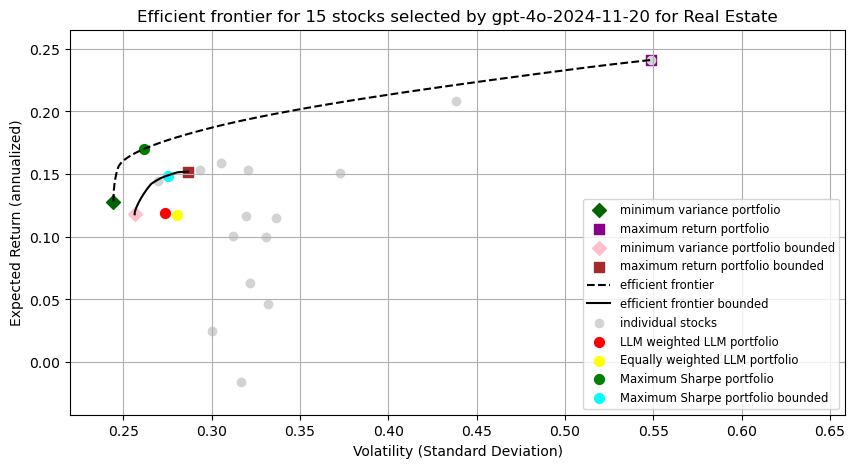

In [1111]:
## I think this is for in-sample data?
plot_frontiers(df_returns, params_llm, sector_name_full, model)

## Plot portfolio performance

In [1112]:
# Weights of all portfolios
weights = {
    f"LLM_weighted_{sector_name}": globals()[f'{model_short}_weights_llm_{sector_name}'],
    f"LLM_equal_{sector_name}": globals()[f'{model_short}_eq_weights_{sector_name}'],
    "LLM Min Var": globals()[f'{model_short}_w_min_var_bounded15_{sector_name}'],
    "LLM Max Ret": globals()[f'{model_short}_w_max_ret_bounded15_{sector_name}'],
    "LLM Max Sharpe": globals()[f'{model_short}_w_max_sharpe_bounded15_{sector_name}']
}

In [1113]:
temp_stock_return = globals()[f'{model_short}_stock_returns_{sector_name}']
temp_stock_return.index = pd.to_datetime(temp_stock_return.index)
first_date = temp_stock_return.index[0]
previous_trading_date = first_date - BDay(1)
full_index = [previous_trading_date] + list(temp_stock_return.index)
cumulative_returns_llm = pd.DataFrame(index=full_index) ## 创建df 只有index-日期 这一列 ## modified 

In [1114]:
i = 0
for name, weight in weights.items():
    temp_stock_return = globals()[f'{model_short}_stock_returns_{sector_name}']
    first_date = temp_stock_return.index[0]
    temp_stock_return.index = pd.to_datetime(temp_stock_return.index)
    previous_trading_date = first_date - BDay(1)
    baseline_row = pd.DataFrame(
        data=np.zeros((1, temp_stock_return.shape[1])),  
        index=[previous_trading_date],                    
        columns=temp_stock_return.columns               
    )
    temp_stock_return_with_baseline = pd.concat([baseline_row, temp_stock_return])
    portfolio_return = (temp_stock_return_with_baseline * weight).sum(axis=1)
    cumulative_returns_llm[name] = (1 + portfolio_return).cumprod()
    i+=1

In [1115]:
cumulative_returns_llm

,LLM_weighted_real_estate,LLM_equal_real_estate,LLM Min Var,LLM Max Ret,LLM Max Sharpe
2025-04-01,1.000000,1.000000,1.000000,1.000000,1.000000
2025-04-02,1.004901,1.004646,1.004455,1.006716,1.005889
2025-04-03,0.973620,0.971139,0.979845,0.969127,0.971637
2025-04-04,0.932707,0.924598,0.937151,0.925542,0.928356
2025-04-07,0.906745,0.899704,0.912650,0.901767,0.904262
2025-04-08,0.885249,0.882032,0.892458,0.884666,0.885993
2025-04-09,0.938246,0.934905,0.946559,0.941399,0.942415
2025-04-10,0.918021,0.910874,0.924461,0.918194,0.920385
2025-04-11,0.931349,0.922295,0.937469,0.929675,0.930743
2025-04-14,0.950863,0.944196,0.958366,0.947632,0.949796


In [1116]:
index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

temp_index_data_outs = index_data_outs.copy()
index_first_date = temp_index_data_outs.index[0]
index_previous_trading_date = index_first_date - BDay(1)
index_baseline_row = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs.shape[1])),  
    index=[index_previous_trading_date],                 
    columns=temp_index_data_outs.columns
)
temp_index_data_outs_with_baseline = pd.concat([index_baseline_row, temp_index_data_outs])

cumulative_returns_llm[index_names[sector_ticker]] = (1 + temp_index_data_outs_with_baseline[ticker]).cumprod()

cumulative_returns_llm.index = pd.to_datetime(cumulative_returns_llm.index)
outsample_data = cumulative_returns_llm.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()


for column in outsample_data.columns:
    if column == f'{full_ticker} {sector_name}':
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column,
                                 line=dict(width=3, color='red')))
    else:
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column))


num_asset = len(df_sector)
fig.update_layout(
    title=f'Cumulative Returns of {num_asset} Asset Portfolios ({model}, equal weight) and {full_ticker} ({sector_name_full}) from Jan 1 to Jun 15',
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified"
)

fig.show()

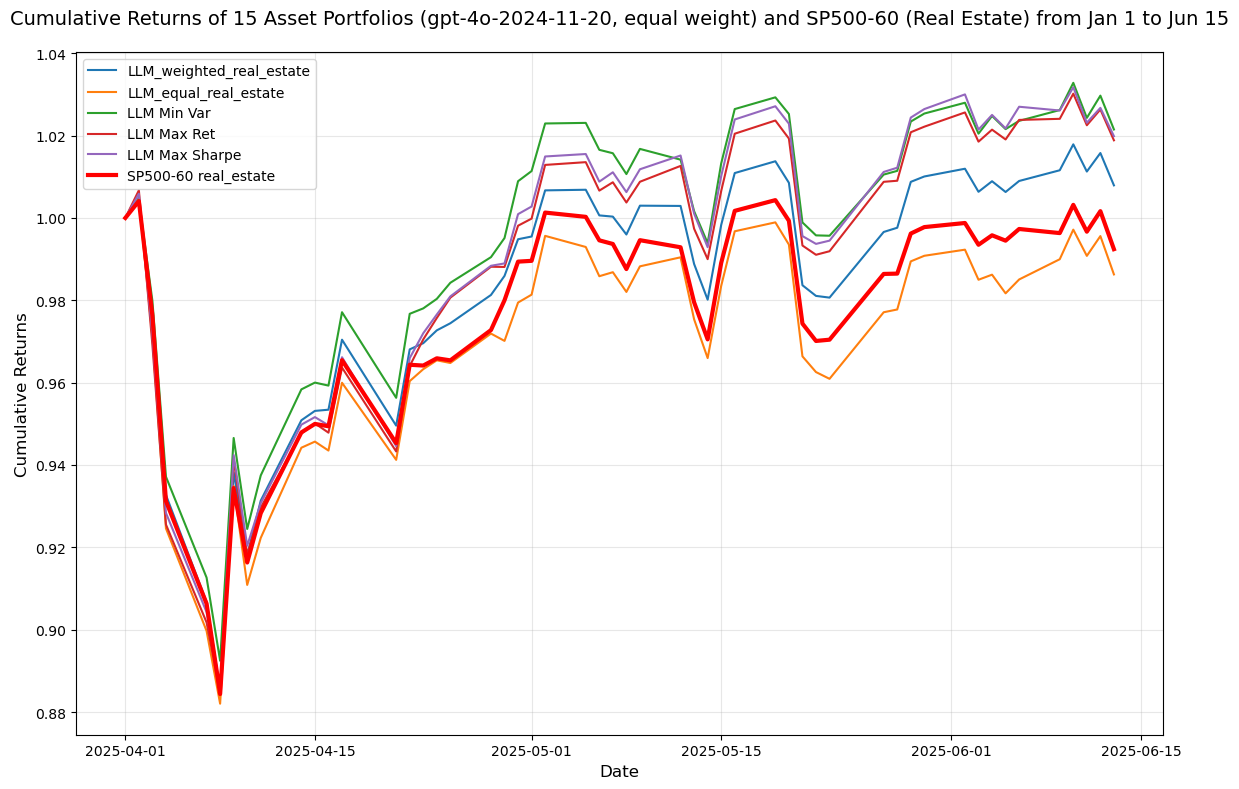

In [1117]:
index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

temp_index_data_outs = index_data_outs.copy()
index_first_date = temp_index_data_outs.index[0]
index_previous_trading_date = index_first_date - BDay(1)
index_baseline_row = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs.shape[1])),  
    index=[index_previous_trading_date],                 
    columns=temp_index_data_outs.columns
)
temp_index_data_outs_with_baseline = pd.concat([index_baseline_row, temp_index_data_outs])

cumulative_returns_llm[index_names[sector_ticker]] = (1 + temp_index_data_outs_with_baseline[ticker]).cumprod()

cumulative_returns_llm.index = pd.to_datetime(cumulative_returns_llm.index)
outsample_data = cumulative_returns_llm.loc[outsample_startdate:outsample_enddate]

fig, ax = plt.subplots(figsize=(12, 8))

for column in outsample_data.columns:
    if column == f'{full_ticker} {sector_name}':
        ax.plot(outsample_data.index, 
                outsample_data[column], 
                linewidth=3, 
                color='red', 
                label=column)
    else:
        ax.plot(outsample_data.index, 
                outsample_data[column], 
                label=column)

num_asset = len(df_sector)
ax.set_title(f'Cumulative Returns of {num_asset} Asset Portfolios ({model}, equal weight) and {full_ticker} ({sector_name_full}) from Jan 1 to Jun 15', 
             fontsize=14, pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Returns', fontsize=12)


ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
# fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## Comparing LLM Models: OpenAI, Anthropic, DeepSeek, Google, and X.AI

In [1118]:
for model, model_short in model_name_mapping.items():
    if model == 'gpt-4o-2024-11-20' and avg_weights:
        csv_filename = f'cached/gpt/4o_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'gpt-4.1' and avg_weights:
        csv_filename = f'cached/gpt/4.1_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'o4-mini' and avg_weights:
        csv_filename = f'cached/gpt/o4-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    # ds
    elif model == 'deepseek-chat' and avg_weights:
        csv_filename = f'cached/ds/dsV3_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'deepseek-reasoner' and avg_weights:
        csv_filename = f'cached/ds/dsR1_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    # claude
    elif model == 'claude-3-7-sonnet-20250219' and avg_weights:
        csv_filename = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'claude-sonnet-4-20250514' and avg_weights:
        csv_filename = f'cached/claude/sonnet-4_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'claude-opus-4-20250514' and avg_weights:
        csv_filename = f'cached/claude/opus-4_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    # gemini
    elif model == 'gemini-2.5-pro-preview-05-06' and avg_weights:
        csv_filename = f'cached/gemini/gemini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    # grok
    elif model == 'grok-3-latest' and avg_weights:
        csv_filename = f'cached/grok/grok3_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    elif model == 'grok-3-mini-latest' and avg_weights:
        csv_filename = f'cached/grok/grok3-mini_avg_weights_assigned/responses15_auto_{sector_name}.csv'
    
    df_sector = pd.read_csv(csv_filename)

    stocks, eq_weights, llm_weights = process_sector_data(df_sector)

    # Assign variables dynamically
    globals()[f'{model_short}_df_{sector_name}'] = df_sector
    globals()[f'{model_short}_stocks_{sector_name}'] = stocks
    globals()[f'{model_short}_eq_weights_{sector_name}'] = eq_weights
    globals()[f'{model_short}_weights_llm_{sector_name}'] = llm_weights

In [1119]:
for model, model_short in model_name_mapping.items():
    globals()[f'{model_short}_stock_returns_{sector_name}'] = df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']]

In [1120]:
for model, model_short in model_name_mapping.items():
    ret_front15, var_front15, ret_max_sharpe15, var_max_sharpe15, ret_front_bounded15, \
        var_front_bounded15, ret_max_sharpe_bounded15, var_max_sharpe_bounded15, w_min_var_bounded15, \
        w_max_ret_bounded15, w_max_sharpe_bounded15 = frontiers(df_returns, globals()[f'{model_short}_stocks_{sector_name}'], 200, lbA, ubA, 0.01, model_short)

    globals()[f'{model_short}_ret_front15_{sector_name}'] = ret_front15
    globals()[f'{model_short}_var_front15_{sector_name}'] = var_front15
    globals()[f'{model_short}_ret_max_sharpe15_{sector_name}'] = ret_max_sharpe15
    globals()[f'{model_short}_var_max_sharpe15_{sector_name}'] = var_max_sharpe15
    globals()[f'{model_short}_ret_front_bounded15_{sector_name}'] = ret_front_bounded15
    globals()[f'{model_short}_var_front_bounded15_{sector_name}'] = var_front_bounded15
    globals()[f'{model_short}_ret_max_sharpe_bounded15_{sector_name}'] = ret_max_sharpe_bounded15
    globals()[f'{model_short}_var_max_sharpe_bounded15_{sector_name}'] = var_max_sharpe_bounded15
    globals()[f'{model_short}_w_min_var_bounded15_{sector_name}'] = w_min_var_bounded15
    globals()[f'{model_short}_w_max_ret_bounded15_{sector_name}'] = w_max_ret_bounded15
    globals()[f'{model_short}_w_max_sharpe_bounded15_{sector_name}'] = w_max_sharpe_bounded15

In [1121]:
temp_stock_return_compare = globals()[f'{model_short}_stock_returns_{sector_name}']

temp_stock_return_compare.index = pd.to_datetime(temp_stock_return_compare.index)
first_date_compare = temp_stock_return_compare.index[0]
previous_trading_date_compare = first_date_compare - BDay(1)
full_index_compare = [previous_trading_date_compare] + list(temp_stock_return_compare.index)

cumulative_returns_compare = pd.DataFrame(index=full_index_compare)

In [1122]:
cumulative_returns_compare ## for checking, not needed in final code

""
2025-04-01
2025-04-02
2025-04-03
2025-04-04
2025-04-07
2025-04-08
2025-04-09
2025-04-10
2025-04-11
2025-04-14


In [1123]:
globals()[f'{model_short}_stock_returns_{sector_name}'] = df_returnsOUT[globals()[f'{model_short}_stocks_{sector_name}']]

In [1124]:
for model_name, model_short in model_name_mapping.items():
    dict_name = f"weights_{model_short}"

    weights_dict = {
        f"{model_short}_weighted_{sector_name}": globals()[f'{model_short}_weights_llm_{sector_name}'],
        f"{model_short}_equal_{sector_name}": globals()[f'{model_short}_eq_weights_{sector_name}'],
        f"{model_short} Min Var": globals()[f'{model_short}_w_min_var_bounded15_{sector_name}'],
        f"{model_short} Max Ret": globals()[f'{model_short}_w_max_ret_bounded15_{sector_name}'],
        f"{model_short} Max Sharpe": globals()[f'{model_short}_w_max_sharpe_bounded15_{sector_name}']
    }
    
    globals()[dict_name] = weights_dict

In [1125]:
model_shorts = ["gpt4o", "gpt4.1", "o4-mini", "sonnet-3.7", "sonnet-4", "opus-4", 
                "dsV3", "dsR1", "gemini", "grok3", "grok3-mini"]

for model_short in model_shorts:
    weights_dict = globals()[f'weights_{model_short}']
    
    temp_stock_return_compare = globals()[f'{model_short}_stock_returns_{sector_name}']

    for name, weight in weights_dict.items():
        temp_stock_return_compare.index = pd.to_datetime(temp_stock_return_compare.index)
        first_date_compare = temp_stock_return_compare.index[0]
        previous_trading_date_compare = first_date_compare - BDay(1)
        baseline_row1 = pd.DataFrame(
            data=np.zeros((1, temp_stock_return_compare.shape[1])),  
            index=[previous_trading_date_compare],                    
            columns=temp_stock_return_compare.columns               
        )
        temp_stock_return_compare_with_baseline = pd.concat([baseline_row1, temp_stock_return_compare])

        portfolio_return_compare = (temp_stock_return_compare_with_baseline * weight).sum(axis=1)
        cumulative_returns_compare[name] = (1 + portfolio_return_compare).cumprod()

print(cumulative_returns_compare.columns)

Index(['gpt4o_weighted_real_estate', 'gpt4o_equal_real_estate',
       'gpt4o Min Var', 'gpt4o Max Ret', 'gpt4o Max Sharpe',
       'gpt4.1_weighted_real_estate', 'gpt4.1_equal_real_estate',
       'gpt4.1 Min Var', 'gpt4.1 Max Ret', 'gpt4.1 Max Sharpe',
       'o4-mini_weighted_real_estate', 'o4-mini_equal_real_estate',
       'o4-mini Min Var', 'o4-mini Max Ret', 'o4-mini Max Sharpe',
       'sonnet-3.7_weighted_real_estate', 'sonnet-3.7_equal_real_estate',
       'sonnet-3.7 Min Var', 'sonnet-3.7 Max Ret', 'sonnet-3.7 Max Sharpe',
       'sonnet-4_weighted_real_estate', 'sonnet-4_equal_real_estate',
       'sonnet-4 Min Var', 'sonnet-4 Max Ret', 'sonnet-4 Max Sharpe',
       'opus-4_weighted_real_estate', 'opus-4_equal_real_estate',
       'opus-4 Min Var', 'opus-4 Max Ret', 'opus-4 Max Sharpe',
       'dsV3_weighted_real_estate', 'dsV3_equal_real_estate', 'dsV3 Min Var',
       'dsV3 Max Ret', 'dsV3 Max Sharpe', 'dsR1_weighted_real_estate',
       'dsR1_equal_real_estate', 'dsR1 Mi

In [1126]:
index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

temp_index_data_outs = index_data_outs.copy()
index_first_date = temp_index_data_outs.index[0]
index_previous_trading_date = index_first_date - BDay(1)
index_baseline_row = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs.shape[1])),  
    index=[index_previous_trading_date],                 
    columns=temp_index_data_outs.columns
)
temp_index_data_outs_with_baseline = pd.concat([index_baseline_row, temp_index_data_outs])

cumulative_returns_compare[index_names[sector_ticker]] = (1 + temp_index_data_outs_with_baseline[ticker]).cumprod()

cumulative_returns_compare.index = pd.to_datetime(cumulative_returns_compare.index)

In [1127]:
cumrets_mean = cumulative_returns_compare.mean().tolist()[:-1]
cumrets_mean = [str(x) for x in cumrets_mean]
with open('metrics/cumulative_returns_all.csv', 'a', encoding='utf-8') as f:
    content = ','.join(cumrets_mean)
    print((f'{sector_name},{content}\n'))
    f.write(f'{sector_name},{content}\n')

real_estate,0.9844769439448291,0.9710127201276486,0.9960579134531515,0.9901243391564857,0.992317024345769,0.978590140452488,0.9724689275914329,0.9954387532833613,0.9848778130170444,0.992785607597766,0.9873990996769788,0.9806284458836714,1.002046930639438,0.9919931965888942,0.9939492980707082,0.9826943965673968,0.9719588133408711,0.996135386095278,0.9817418933229237,0.9930393370324331,0.9925971652930138,0.9914146721379284,1.010871023823626,0.9934934548810792,1.001717348932103,0.9890495360834031,0.9790613163284593,1.0056231674794642,0.9849809582650787,0.9962419043179941,0.9913435210929897,0.9881934898157917,1.004392787025971,0.9920613207496524,0.9999563550020435,0.9878850592221274,0.9769028763925701,0.9979514153702321,0.9936834582479199,0.994320773100858,0.9800420118457052,0.9752174675424387,0.9970854391656447,0.9918766659013272,0.9933503624355637,0.9883649930593148,0.9883293748801093,1.007142738405742,0.9891318612846731,1.000938638442235,0.9886021241931016,0.9785266254563662,1.002993302

In [1128]:
print(cumulative_returns_compare.columns)

Index(['gpt4o_weighted_real_estate', 'gpt4o_equal_real_estate',
       'gpt4o Min Var', 'gpt4o Max Ret', 'gpt4o Max Sharpe',
       'gpt4.1_weighted_real_estate', 'gpt4.1_equal_real_estate',
       'gpt4.1 Min Var', 'gpt4.1 Max Ret', 'gpt4.1 Max Sharpe',
       'o4-mini_weighted_real_estate', 'o4-mini_equal_real_estate',
       'o4-mini Min Var', 'o4-mini Max Ret', 'o4-mini Max Sharpe',
       'sonnet-3.7_weighted_real_estate', 'sonnet-3.7_equal_real_estate',
       'sonnet-3.7 Min Var', 'sonnet-3.7 Max Ret', 'sonnet-3.7 Max Sharpe',
       'sonnet-4_weighted_real_estate', 'sonnet-4_equal_real_estate',
       'sonnet-4 Min Var', 'sonnet-4 Max Ret', 'sonnet-4 Max Sharpe',
       'opus-4_weighted_real_estate', 'opus-4_equal_real_estate',
       'opus-4 Min Var', 'opus-4 Max Ret', 'opus-4 Max Sharpe',
       'dsV3_weighted_real_estate', 'dsV3_equal_real_estate', 'dsV3 Min Var',
       'dsV3 Max Ret', 'dsV3 Max Sharpe', 'dsR1_weighted_real_estate',
       'dsR1_equal_real_estate', 'dsR1 Mi

## Difference between benchmark (index) and portfolio

In [1129]:
cumulative_returns_diff_comp = cumulative_returns_compare.copy()

for model, model_short in model_name_mapping.items():
    cumulative_returns_diff_comp[f'{model_short}_weighted_{sector_name}'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short}_weighted_{sector_name}']
    cumulative_returns_diff_comp[f'{model_short}_equal_{sector_name}'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short}_equal_{sector_name}']
    cumulative_returns_diff_comp[f'{model_short} Min Var'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short} Min Var']
    cumulative_returns_diff_comp[f'{model_short} Max Ret'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short} Max Ret']
    cumulative_returns_diff_comp[f'{model_short} Max Sharpe'] = cumulative_returns_diff_comp[f'{full_ticker} {sector_name}'] - cumulative_returns_diff_comp[f'{model_short} Max Sharpe']

In [1130]:
cumulative_returns_diff_comp = cumulative_returns_diff_comp.drop(f'{full_ticker} {sector_name}', axis=1)

Negative value means portfolio outperforms the index (because it is the difference between index and portfolio performance, not vice versa).

In [1131]:
cumulative_returns_diff_comp.mean()

gpt4o_weighted_real_estate        -0.007704
gpt4o_equal_real_estate            0.005760
gpt4o Min Var                     -0.019285
gpt4o Max Ret                     -0.013352
gpt4o Max Sharpe                  -0.015544
gpt4.1_weighted_real_estate       -0.001817
gpt4.1_equal_real_estate           0.004304
gpt4.1 Min Var                    -0.018666
gpt4.1 Max Ret                    -0.008105
gpt4.1 Max Sharpe                 -0.016013
o4-mini_weighted_real_estate      -0.010626
o4-mini_equal_real_estate         -0.003856
o4-mini Min Var                   -0.025274
o4-mini Max Ret                   -0.015220
o4-mini Max Sharpe                -0.017176
sonnet-3.7_weighted_real_estate   -0.005922
sonnet-3.7_equal_real_estate       0.004814
sonnet-3.7 Min Var                -0.019363
sonnet-3.7 Max Ret                -0.004969
sonnet-3.7 Max Sharpe             -0.016267
sonnet-4_weighted_real_estate     -0.015824
sonnet-4_equal_real_estate        -0.014642
sonnet-4 Min Var                

The table above is used to compose the Table 5.2 with portfolio performances based on out-of-sample cumulative returns.

In [1132]:
outsample_data_diff_comp = cumulative_returns_diff_comp.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()

for column in outsample_data_diff_comp.columns:
    fig.add_trace(go.Scatter(x=outsample_data_diff_comp.index.sort_values(),
                                y=outsample_data_diff_comp[column],
                                mode='lines',
                                name=column))

fig.add_trace(go.Scatter(x=outsample_data.index.sort_values(),
                            y=np.array([0] * len(outsample_data)),
                            mode='lines',
                            name='Zero Line',
                            line=dict(width=2, color='red')))

num_asset = len(df_sector)
fig.update_layout(
    title=f'Differences between index performance ({full_ticker} {sector_name}) and {num_asset} asset portfolios from Jan 1 to Jun 15',
    xaxis_title='Date',
    yaxis_title='Difference',
    hovermode="x unified"
)

fig.show()



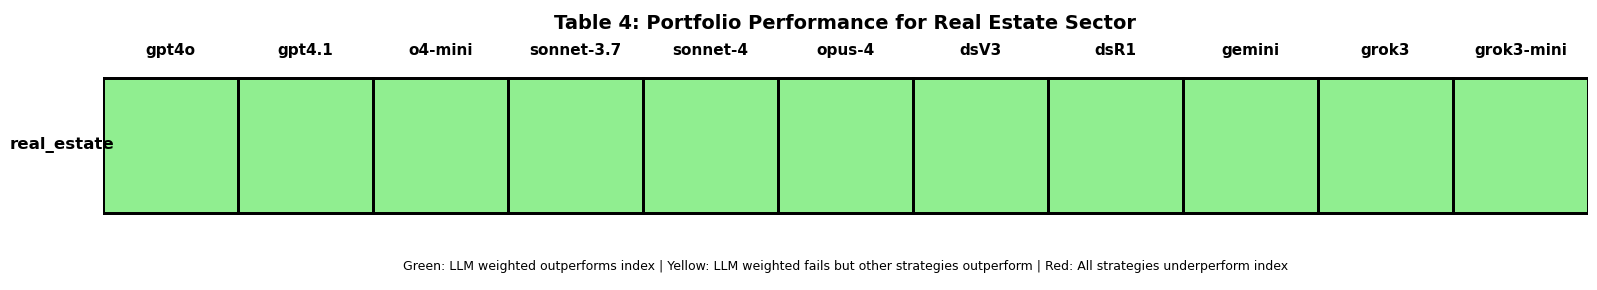

In [1133]:
import matplotlib.patches as patches

data = cumulative_returns_diff_comp.mean()


models = []
for idx in data.index:
    model = idx.split('_')[0] 
    if ' ' in model:  
        model = idx.split(' ')[0]
    if model not in models:
        models.append(model)

colors = []

for model in models:
    weighted_value = None
    other_values = []
    
    for idx, value in data.items():
        if idx.startswith(model):
            if 'weighted' in idx:
                weighted_value = value
            else:
                other_values.append(value)
    
    if weighted_value is not None and weighted_value < 0:
        colors.append('#90EE90')
    elif weighted_value is not None and any(v < 0 for v in other_values):
        colors.append('#FFD700') 
    else:
        colors.append('#FFB6C1')

fig, ax = plt.subplots(figsize=(len(models)*1.5, 3))
ax.set_xlim(0, len(models))
ax.set_ylim(0, 2)
ax.set_aspect('equal')

for j, (model, color) in enumerate(zip(models, colors)):
    
    rect = patches.Rectangle((j, 0.5), 1, 1, 
                           linewidth=2, edgecolor='black', facecolor=color)
    ax.add_patch(rect)

for j, model in enumerate(models):
    ax.text(j+0.5, 1.7, model, ha='center', va='center', 
            fontweight='bold', fontsize=11)

ax.text(-0.3, 1, sector_name, ha='center', va='center', 
        fontweight='bold', fontsize=12)

ax.axhline(y=0.5, xmin=0, xmax=1, color='black', linewidth=2)
ax.axhline(y=1.5, xmin=0, xmax=1, color='black', linewidth=2)
for j in range(len(models) + 1):
    ax.axvline(x=j, ymin=0.5/2, ymax=1.5/2, color='black', linewidth=2)

ax.text(len(models)/2, 1.9, f'Table 4: Portfolio Performance for {sector_name_full} Sector', 
        ha='center', va='center', fontweight='bold', fontsize=14)

legend_text = ('Green: LLM weighted outperforms index | '
               'Yellow: LLM weighted fails but other strategies outperform | '
               'Red: All strategies underperform index')
ax.text(len(models)/2, 0.1, legend_text, ha='center', va='center', fontsize=9)

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

plt.tight_layout()
plt.show()

## Summary metrics preparation

In [1134]:
sector_diff_summary = cumulative_returns_diff_comp.mean()

sector_results = pd.DataFrame({
    'sector': sector_name,
    'portfolio': sector_diff_summary.index,
    'difference': sector_diff_summary.values
})

csv_filename = 'difference/sector_performance_differences_stocks15_Apr.csv'

if os.path.exists(csv_filename):
    existing_data = pd.read_csv(csv_filename)
    existing_data = existing_data[existing_data['sector'] != sector_name]
    combined_data = pd.concat([existing_data, sector_results], ignore_index=True)
    combined_data.to_csv(csv_filename, mode='w', header=True, index=False)
    print(f"Updated data for sector: {sector_name}")
else:
    sector_results.to_csv(csv_filename, mode='w', header=True, index=False)
    print(f"Created new file with sector: {sector_name}")

print(f"Data has been saved to {csv_filename}")
print(f"Current sector: {sector_name}")
print(f"Saved {len(sector_results)} indicators")

Updated data for sector: real_estate
Data has been saved to difference/sector_performance_differences_stocks15_Apr.csv
Current sector: real_estate
Saved 55 indicators


## Volatilities

In [1135]:
for model_short in model_shorts:

    sector_mean = cumulative_returns_compare[f'{model_short}_weighted_{sector_name}'].mean()
    sector_diff_sq = cumulative_returns_compare[f'{model_short}_weighted_{sector_name}'].apply(lambda x: (x - sector_mean)**2)
    sector_sumdiff = sector_diff_sq.sum() / cumulative_returns_compare.size
    sector_volatility = round(sqrt(sector_sumdiff), 5)

    print(sector_name, sector_volatility, model_short)
    with open('metrics/portfolio_volatilities.csv', 'a', encoding='utf-8') as f:
        f.write(f'{model_short},{sector_name},{sector_volatility}\n')

real_estate 0.00404 gpt4o
real_estate 0.00399 gpt4.1
real_estate 0.00402 o4-mini
real_estate 0.00397 sonnet-3.7
real_estate 0.00435 sonnet-4
real_estate 0.00412 opus-4
real_estate 0.00412 dsV3
real_estate 0.00394 dsR1
real_estate 0.00378 gemini
real_estate 0.00451 grok3
real_estate 0.00455 grok3-mini


## Sector Index Volatility (not finished)

In [1136]:
# globals()[f'insample_stock_returns_{sector_name}'] = df_returns[globals()[f'stocks_{sector_name}']]
# temp_stock_return_insample = globals()[f'insample_stock_returns_{sector_name}']
# cumulative_returns_gpt_insample = pd.DataFrame(index=temp_stock_return_insample.index)
# cumulative_returns_gpt_insample

# i = 0
# for name, weight in weights.items():
#     temp_stock_return = globals()[f'insample_stock_returns_{sector_name}']
#     portfolio_return = (temp_stock_return * weight).sum(axis=1)
#     cumulative_returns_gpt_insample[name] = (1 + portfolio_return).cumprod()
#     i+=1

# print(cumulative_returns_gpt_insample.columns)

# cumulative_returns_gpt_insample[index_names[sector_ticker]] = (1 + index_data_ins[ticker]).cumprod()

# cumulative_returns_gpt_insample.index = pd.to_datetime(cumulative_returns_gpt_insample.index)
# insample_data = cumulative_returns_gpt_insample.loc[insample_startdate:insample_enddate]


# insample_data

## Portfolio Performance

Plot with Scrollable Legend (Display Only)

In [1137]:
temp_index_data_outs_compare = index_data_outs.copy()

temp_index_data_outs_compare.index = pd.to_datetime(temp_index_data_outs_compare.index)

index_first_date_compare = temp_index_data_outs_compare.index[0]
index_previous_trading_date_compare = index_first_date_compare - BDay(1)

index_baseline_row_compare = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs_compare.shape[1])),  
    index=[index_previous_trading_date_compare],                 
    columns=temp_index_data_outs_compare.columns               
)

temp_index_data_outs_compare_with_baseline = pd.concat([index_baseline_row_compare, temp_index_data_outs_compare])
# ##above is to add a baseline row with zeros to the index data outs compare dataframe##

index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

cumulative_returns_compare[index_names[sector_ticker]] = (1 + temp_index_data_outs_compare_with_baseline[ticker]).cumprod() ##

cumulative_returns_compare.index = pd.to_datetime(cumulative_returns_compare.index)
outsample_data = cumulative_returns_compare.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()

for i, column in enumerate(outsample_data.columns):
    if column == f'{full_ticker} {sector_name}':
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column,
                                 line=dict(width=3, color='red')))

    else:
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column))

num_asset = len(df_sector)
fig.update_layout(
    title=f'Cumulative Returns of Portfolios composed by different LLMs and {full_ticker} ({sector_name_full}) from Apr 1 to Jun 15, 2025', 
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified",
    height=600
)

fig.update_layout(legend=dict(orientation = "v", yanchor="top",y=1,xanchor="left", x=1.02))

fig.show()

Plot with Multi-Column Legend (For Download/Export)

In [1138]:
temp_index_data_outs_compare = index_data_outs.copy()

temp_index_data_outs_compare.index = pd.to_datetime(temp_index_data_outs_compare.index)

index_first_date_compare = temp_index_data_outs_compare.index[0]
index_previous_trading_date_compare = index_first_date_compare - BDay(1)

index_baseline_row_compare = pd.DataFrame(
    data=np.zeros((1, temp_index_data_outs_compare.shape[1])),  
    index=[index_previous_trading_date_compare],                 
    columns=temp_index_data_outs_compare.columns               
)

temp_index_data_outs_compare_with_baseline = pd.concat([index_baseline_row_compare, temp_index_data_outs_compare])
# ##above is to add a baseline row with zeros to the index data outs compare dataframe##

index_names = {
    sector_ticker: f'{full_ticker} {sector_name}'
}

cumulative_returns_compare[index_names[sector_ticker]] = (1 + temp_index_data_outs_compare_with_baseline[ticker]).cumprod() ##

cumulative_returns_compare.index = pd.to_datetime(cumulative_returns_compare.index)
outsample_data = cumulative_returns_compare.loc[outsample_startdate:outsample_enddate]

fig = go.Figure()

for i, column in enumerate(outsample_data.columns):
    if column == f'{full_ticker} {sector_name}':
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column,
                                 line=dict(width=3, color='red')))

    else:
        fig.add_trace(go.Scatter(x=outsample_data.index,
                                 y=outsample_data[column],
                                 mode='lines',
                                 name=column))

num_asset = len(df_sector)
fig.update_layout(
    title=f'Cumulative Returns of Portfolios composed by different LLMs and {full_ticker} ({sector_name_full}) from Apr 1 to Jun 15, 2025', 
    title_x = 0.5,
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    hovermode="x unified",
    width=1400,        
    height=800,
    margin=dict(b=150) 
)

# fig.update_layout(legend=dict(orientation = "v", yanchor="top",y=1,xanchor="left", x=1.02))
fig.update_layout(legend=dict(
        orientation="h", 
        yanchor="top",
        y=-0.15,  
        xanchor="center",
        x=0.5,
        font=dict(size=10)
    ))

fig.show()


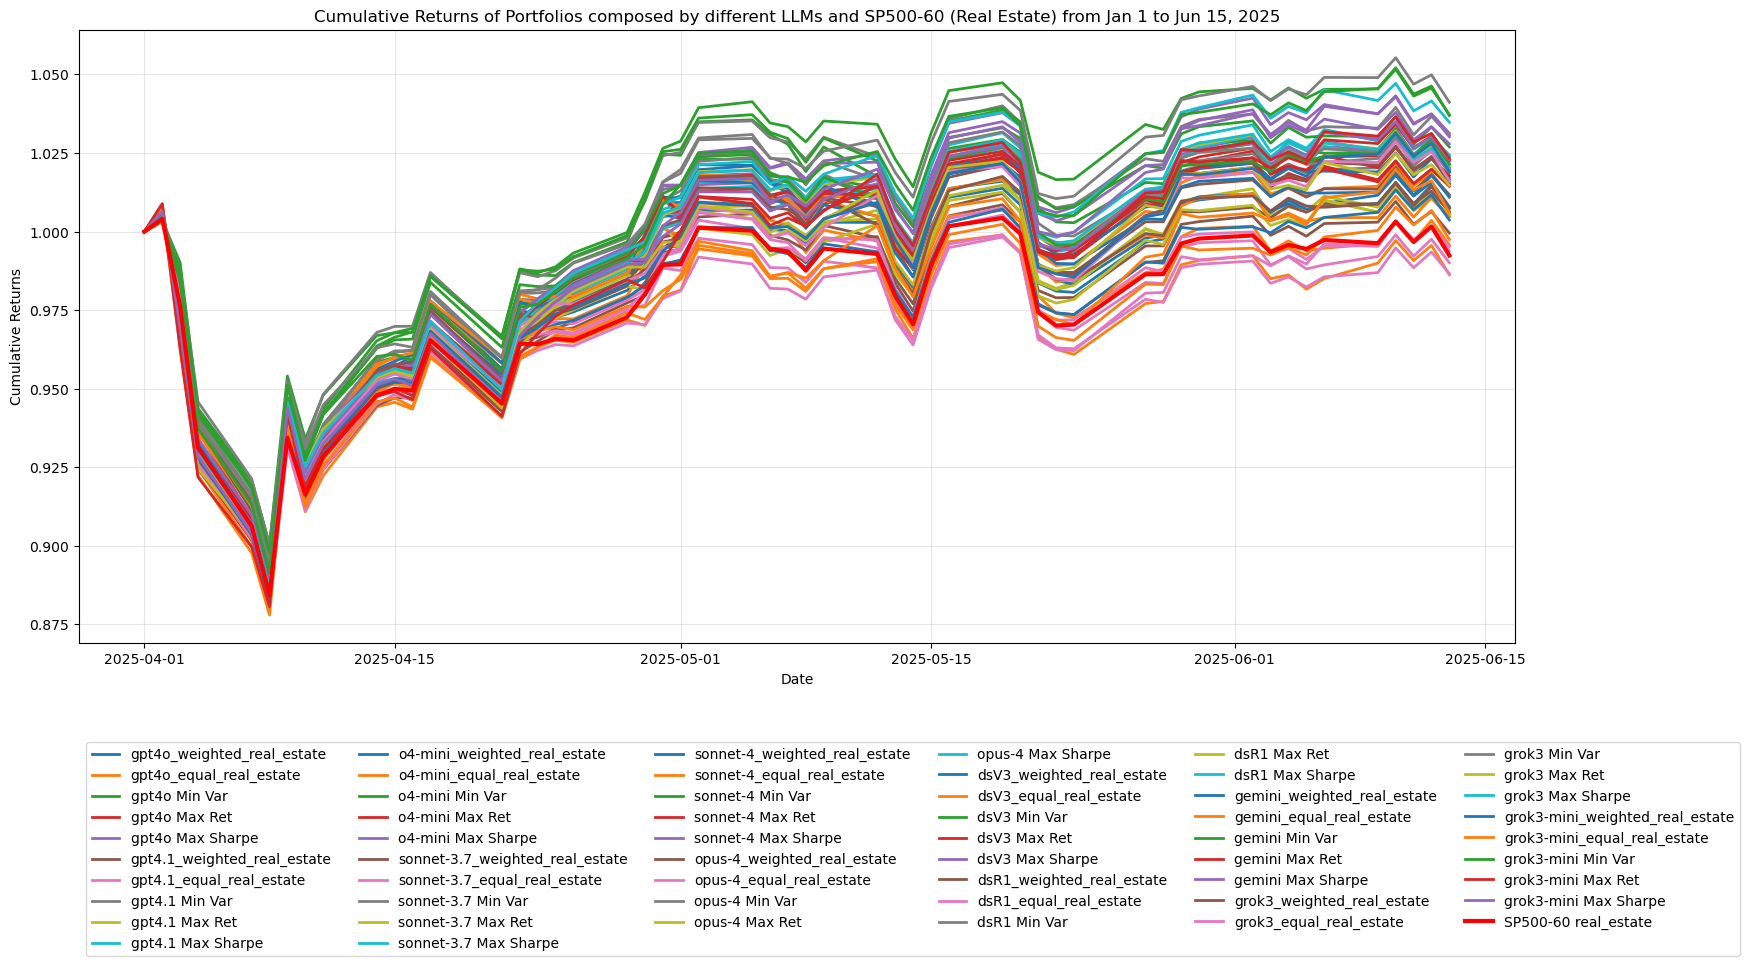

In [1139]:
fig, ax = plt.subplots(figsize=(18,10))

for column in outsample_data.columns:
    if column == f'{full_ticker} {sector_name}':
        ax.plot(outsample_data.index, outsample_data[column], 
               linewidth=3, color='red', label=column)
    else:
        ax.plot(outsample_data.index, outsample_data[column], 
               linewidth=2, label=column)

ax.set_title(f'Cumulative Returns of Portfolios composed by different LLMs and {full_ticker} ({sector_name_full}) from Jan 1 to Jun 15, 2025')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
ax.legend(bbox_to_anchor=(0, -0.15), loc='upper left', ncol=6)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()